# Celltype QC

In [1]:
!date

Tue Aug 20 13:59:02 PDT 2024


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import sklearn

import warnings
warnings.filterwarnings('ignore')

In [4]:
input_dir = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/'

In [5]:
adata = sc.read_h5ad(input_dir+'scANVI_label.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 74327 × 36385
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'C_scANVI', 'C_scANVI_simple'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'C_scANVI_simple_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

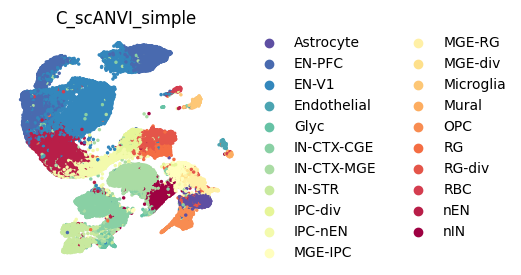

In [7]:
plt.rcParams['figure.figsize']=3,3

sc.pl.umap(adata,color=['C_scANVI_simple',
                       ],
           size=25,
           ncols=4,
           palette='Spectral_r',
       #    legend_loc='on data',
           frameon=False,
          )

In [8]:
##fix celltype palette 

cmap = pd.read_csv('celltype_colors.csv')

adata.uns['C_scANVI_simple_colors'] = cmap['1']

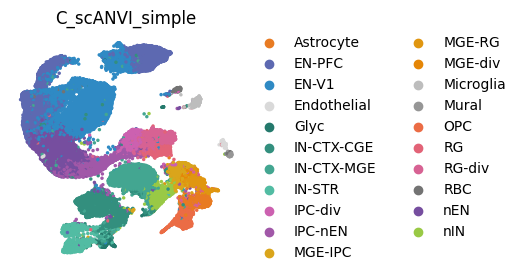

In [9]:
plt.rcParams['figure.figsize']=3,3

sc.pl.umap(adata,color=['C_scANVI_simple',
                       ],
           size=25,
           ncols=4,
       #    legend_loc='on data',
           frameon=False,
          )

In [10]:
[i for i in adata.var_names if i.startswith('H3')]

['H3F3A', 'H3.Y', 'H3F3C', 'H3F3B']

In [11]:
markers=['CRYAB',#:'RG',
         'EGFR',#:'Astrocyte',
         'HES5',#:'MGE-RG
         'PCDH15',#:'OPC'
         'ASCL1',#'MGE-RG/MGE-div'
         'EOMES',#:'IPC'
         'NEUROG2',#:'IPC'
         'NEUROD2',#:'IPC/nEN'
         'ASTN2',#:'EN-PFC'
         'DOK5',#:'EN-V1'
         'SATB2',#:'EN'
         'DLX2',#:'MGE-IPC'
         'LHX6',#:'IN-CTX_MGE'
         'SP8',#:'IN-CTX_CGE'
         'SIX3',#:'IN-STR'
         'PECAM1',#:'Endothelial'
         'FOXC2',#:'Mural'
         'AIF1',#:'Microglia'
         'HBA2',#:'RBC'
        'TOP2A',#:'Div',
         'MIR7-3HG',#:'Glycolysis
        ]

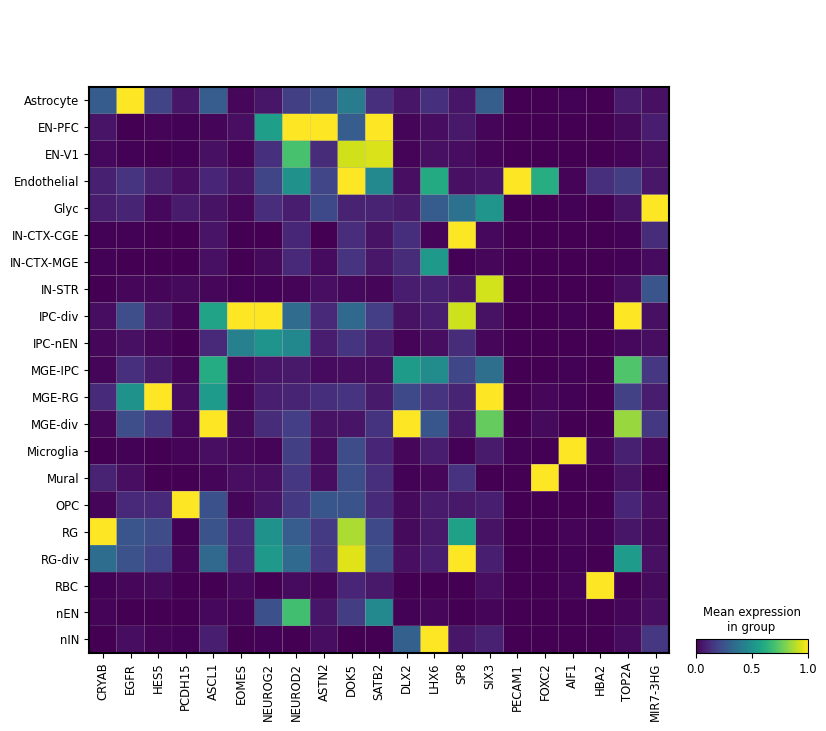

In [12]:
sc.pl.matrixplot(adata,
                 markers,
                 groupby='C_scANVI_simple',
                 standard_scale='var',
                )

In [13]:
celltype_reorder = ['RG','RG-div','Astrocyte','OPC','MGE-RG','MGE-IPC','MGE-div','nIN','IN-CTX-MGE','IN-CTX-CGE','IN-STR','Glyc',
 'IPC-div','IPC-nEN','nEN','EN-V1','EN-PFC','Endothelial','Mural','Microglia','RBC']
 

In [14]:
marker_reorder = ['CRYAB','EGFR','PCDH15','HES5','ASCL1','DLX2','LHX6','NXPH1','SP8','SIX3',
                  'MIR7-3HG','EOMES','NEUROG2','NEUROD2','SATB2','ASTN2','PECAM1','FOXC2','AIF1',
                  'HBA2','TOP2A'
]

In [15]:
adata.obs.C_scANVI_simple.cat.reorder_categories(celltype_reorder, inplace=True)

In [16]:
adata.uns['C_scANVI_simple_colors'] = list(map(dict(zip(cmap['0'],cmap['1'])).get, celltype_reorder))

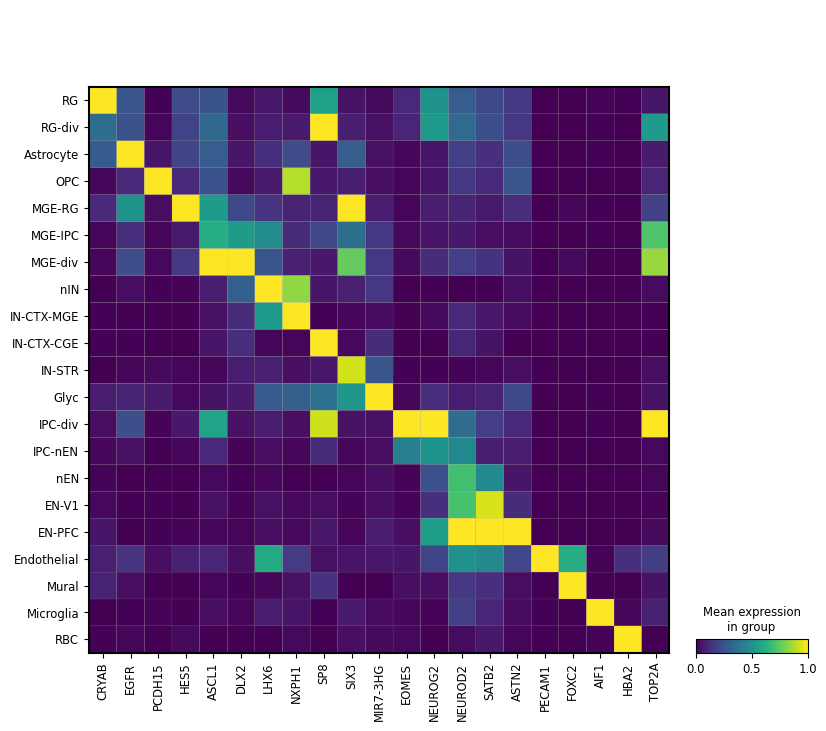

In [17]:
sc.pl.matrixplot(adata,
                 marker_reorder,
                 groupby='C_scANVI_simple',
                 standard_scale='var',
               #  save='celltype_expression.pdf',
                # row_colors=conf_mat.columns.map(color_dict),
                )

In [18]:
mat = sc.get.obs_df(adata,
            keys=["C_scANVI_simple", *marker_reorder],
             )

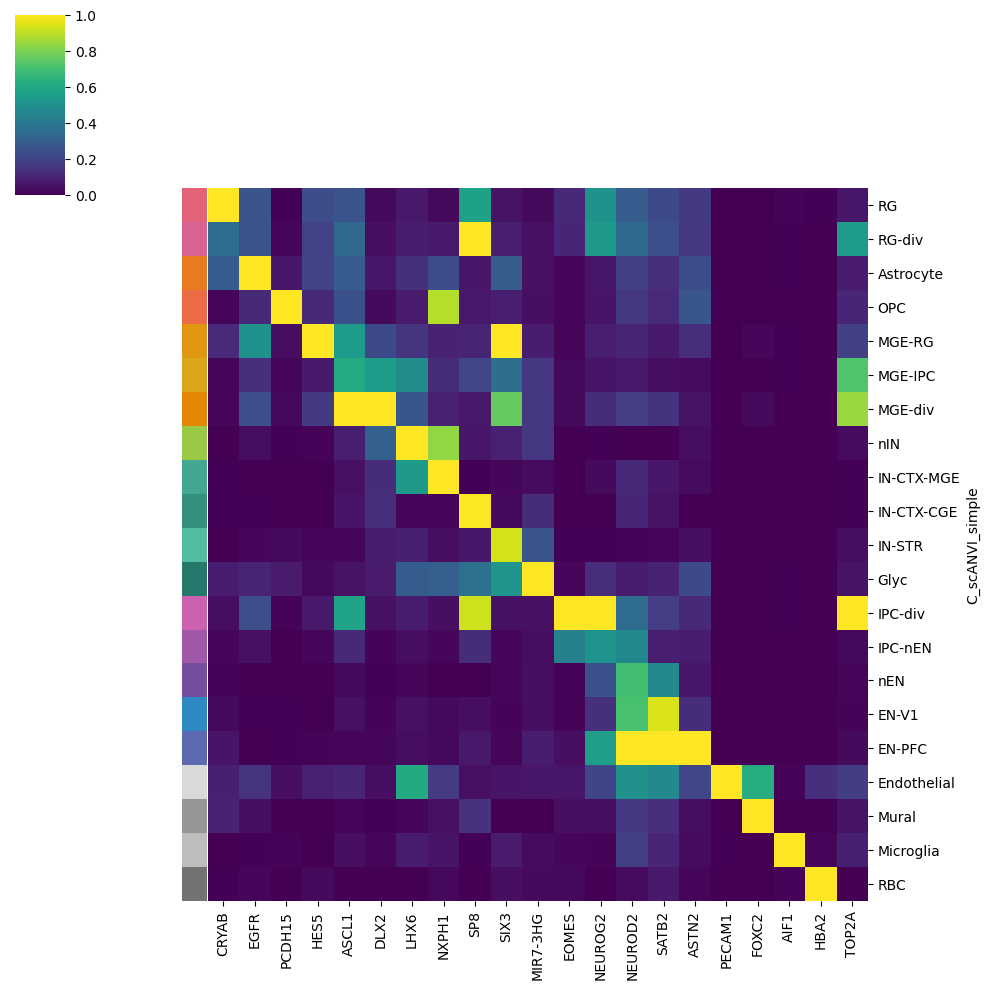

In [19]:
sns.clustermap(mat.groupby('C_scANVI_simple').mean(),
               row_cluster=False,
               col_cluster=False,
               standard_scale=1,
               row_colors=adata.uns['C_scANVI_simple_colors'],
               cmap='viridis',
                  )

In [20]:
# subtract the minimum and
#     divide each by its maximum

In [21]:
standardized = mat.groupby('C_scANVI_simple').mean()

subtract = standardized.min()

standardized = (standardized - subtract) / (
            standardized.max() - standardized.min())

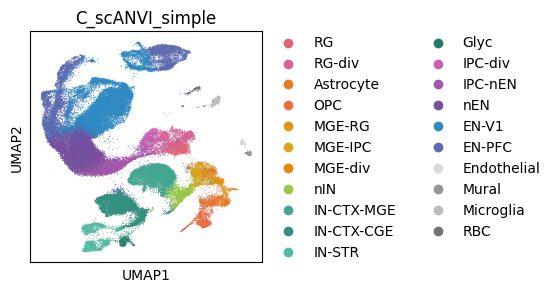

In [22]:
sc.pl.umap(adata,
           color='C_scANVI_simple'
          )

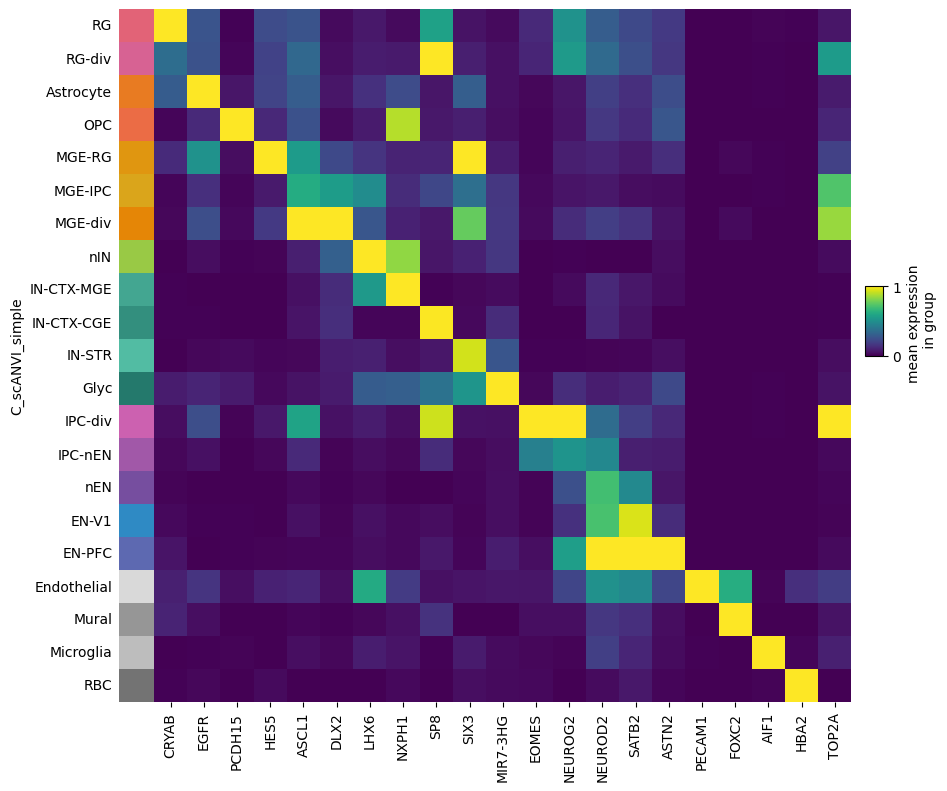

In [23]:
fig, ax = plt.subplots(1,1, figsize = (9,9))

group_names = adata.obs.C_scANVI_simple.cat.categories
data = standardized
data['C_scANVI_simple'] = adata.obs.C_scANVI_simple.cat.categories



sns.heatmap(data.drop(['C_scANVI_simple'], axis=1),
                cmap ='viridis' ,
                cbar=False,
                # linewidths=.05,
            ax=ax )




ax.tick_params(axis='y', which='major', pad=30, length=0, ) # extra padding to leave room for the row colors


for i, color in enumerate(adata.uns['C_scANVI_simple_colors'] ):
    ax.add_patch(plt.Rectangle(xy=(-0.05, i), width=0.05, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))




axins = inset_axes(ax, width = "2.5%", height = "10%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0.5, 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)

fig.colorbar(ax.collections[0], cax = axins, orientation = 'vertical', label='mean expression \n in group',  ticks=[0, 1.0])


# fig.savefig('./plots/celltype_marker_heatmap.pdf')



In [26]:
adata

AnnData object with n_obs × n_vars = 74327 × 36385
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'C_scANVI', 'C_scANVI_simple'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'C_scANVI_simple_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [31]:
# sc.pl.umap(adata, 
#            color=marker_reorder, 
#            ncols=5,
#            vmax='p99',
#            size=10
#           )

# Batch QC

In [32]:
batch_dict = {'-0':'-GW16_1',
              '-1':'-GW16_2',
              '-2':'-GW17_1',
              '-3':'-GW21_1',
              '-4':'-GW21_2',
              '-5':'-GW23_1'
             }

new_names = adata.obs_names.copy()

for key, value in batch_dict.items():
    new_names = new_names.str.replace(key, value)
    
adata.obs['alt_obs_names'] = new_names

In [34]:
adata.obs['age'] = adata.obs['alt_obs_names'].str[-6:].str[:-2].astype('category') 

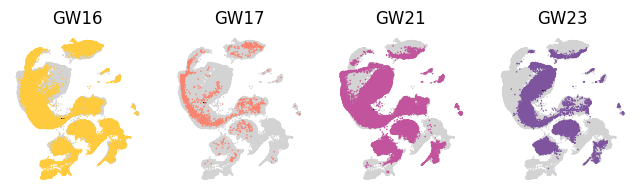

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8,2))

for i, ax in zip(adata.obs.age.cat.categories.tolist(), axs.ravel()):
    sc.pl.umap(adata,color=['age',
                       ],
           title=i,
           size=5,
           ncols=4,
           palette=['#FFCB3E','#FB836F','#C1549C','#7E549F'],
       #    legend_loc='on data',
           frameon=False,
           groups=[i],
           ax=ax,
           show=False,
               legend_loc='on data',
            legend_fontsize=0,
           na_in_legend=False,
          )
    
# plt.savefig('./plots/age_umaps.pdf')

plt.show()


In [105]:
adata.obs.groupby('C_scANVI_simple')['age'

In [57]:
df = adata.obs.groupby('C_scANVI_simple')['age'].value_counts(normalize=True)

df = pd.DataFrame(df).unstack()  

df.columns = df.columns.droplevel(0)

colormap = dict(zip(adata.obs['age'].cat.categories.tolist(),adata.uns['age_colors']))

<Axes: xlabel='C_scANVI_simple'>

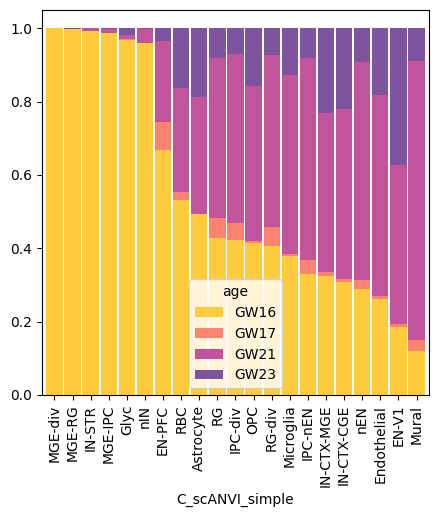

In [58]:
plt.rcParams["figure.figsize"] = 5,5

df.sort_values(by='GW16',ascending=False).plot.bar(stacked=True,color=colormap,width=.9)

# plt.savefig('./plots/age_barplot.pdf')

In [65]:
pivot = df.sort_values(by='GW16',ascending=False).copy()

In [66]:
pivot

age,GW16,GW17,GW21,GW23
C_scANVI_simple,,,,
MGE-div,1.000000,0.000000,0.000000,0.000000
MGE-RG,0.998580,0.000000,0.000000,0.001420
IN-STR,0.991655,0.001854,0.006490,0.000000
MGE-IPC,0.988426,0.000000,0.009259,0.002315
Glyc,0.968978,0.001825,0.010949,0.018248
nIN,0.958609,0.000000,0.038631,0.002759
EN-PFC,0.667824,0.076730,0.219536,0.035911
RBC,0.532751,0.021834,0.283843,0.161572
Astrocyte,0.494727,0.000000,0.318313,0.186961


In [101]:
color_dict = dict(zip(adata.obs.C_scANVI_simple.cat.categories,adata.uns['C_scANVI_simple_colors']))

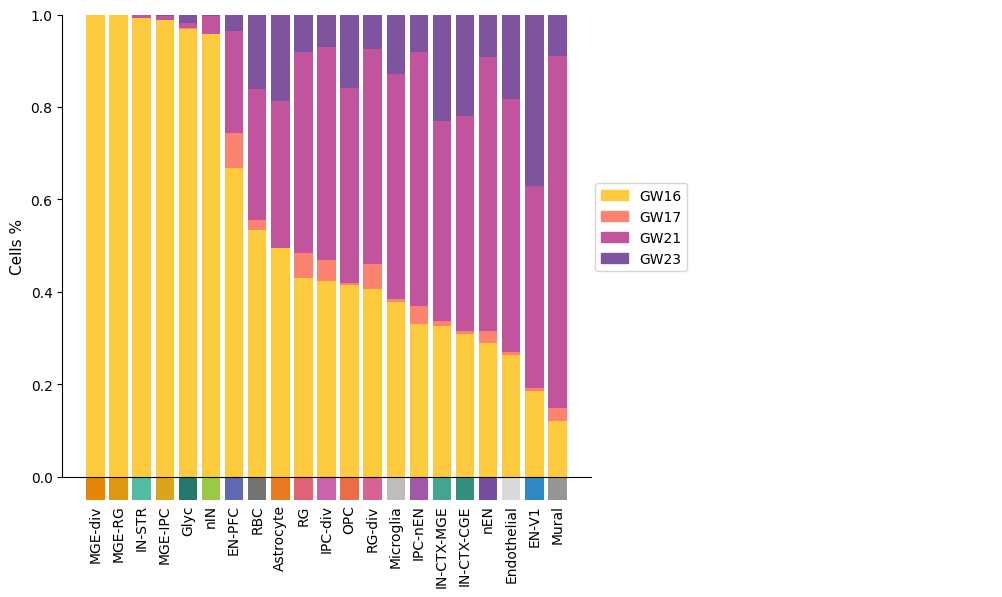

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [5, 3]})

width = 0.8     # the width of the bars: can also be len(x) sequence

palette = sns.color_palette(palette=colormap.values(),n_colors=4)

ax[0].bar(pivot.index, pivot["GW16"], width, color=palette[0])
ax[0].bar(pivot.index, pivot["GW17"], width, bottom=pivot["GW16"], color=palette[1])
ax[0].bar(pivot.index, pivot["GW21"], width, bottom=sum([pivot["GW16"], pivot["GW17"]]), color=palette[2])
ax[0].bar(pivot.index, pivot["GW23"], width, bottom=sum([pivot["GW16"], pivot["GW17"],pivot["GW21"]]), color=palette[3])


ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)

ax[0].set_ylabel('Cells %', fontsize=11)
ax[0].tick_params(axis='x', labelrotation=90)

ax[0].tick_params(axis='x', which='major', pad=20, length=0, ) # extra padding to leave room for the row colors

for i, color in enumerate(pivot.index.map(color_dict)):
    ax[0].add_patch(plt.Rectangle(xy=((i-0.4), -0.05), width=0.8, height=0.05, color=color, lw=0,
                               transform=ax[0].get_xaxis_transform(), clip_on=False))




colors = {"GW16":palette[0], 
          "GW17":palette[1],
          "GW21":palette[2],
          "GW23":palette[3]
         }         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]




ax[1].legend(handles, labels, bbox_to_anchor=(0.01, 0.15, 0.05, 0.5))

ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].spines.bottom.set_visible(False)
ax[1].spines.left.set_visible(False)

ax[1].tick_params( 
    bottom=False,        
    labelbottom=False, 
    left=False,
    labelleft=False, 
            ) 

fig.savefig('./plots/age_proportions.pdf')

In [48]:
df = adata.obs.groupby('C_scANVI_simple')['batch'].value_counts(normalize=True)

df = pd.DataFrame(df).unstack()  

df.columns = df.columns.droplevel(0)

#colormap = dict(zip(adata.obs['age'].cat.categories.tolist(),adata.uns['age_colors']))

<Axes: xlabel='C_scANVI_simple'>

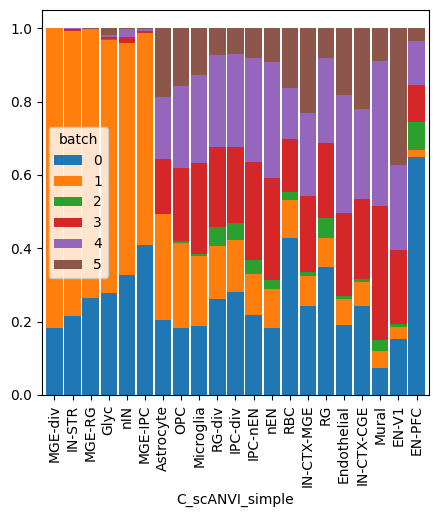

In [49]:
plt.rcParams["figure.figsize"] = 5,5

df.sort_values(by=['1'],ascending=False).plot.bar(stacked=True,
                                          #      color=colormap,
                                                width=.9)

#plt.savefig('./plots/age_barplot.pdf')